<a href="https://colab.research.google.com/github/nguyenthanhtuhcm/docker-basic/blob/main/face_clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
cd /content/drive/My Drive/Cao Học/ThiGiacUngDung/baitap/FaceRecognition/faces_dataset

/content/drive/My Drive/Cao Học/ThiGiacUngDung/baitap/FaceRecognition/faces_dataset


In [ ]:
pip install face_recognition

     |████████████████████████████████| 100.1 MB 23 kB/s 
  Created wheel for face-recognition-models: filename=face_recognition_models-0.3.0-py2.py3-none-any.whl size=100566185 sha256=57f9c8ba9a487699b1b23c54867108de7616a3a5bca28ddb7c48e0a0039a7f61
  Stored in directory: /root/.cache/pip/wheels/d6/81/3c/884bcd5e1c120ff548d57c2ecc9ebf3281c9a6f7c0e7e7947a
Successfully built face-recognition-models


In [ ]:
%%writefile listpath.py
import os
def list_files(path, partname):
    filelist = []
    for root, dirs, files in os.walk(path):
        for file in files:
            if file.endswith(partname):
                filelist.append(os.path.join(root,file))
    return filelist

Overwriting listpath.py


Encoding từng shot:
- Đầu vào : thư mục chứa các shot video
- Đầu ra : mỗi shot, tạo thư mục shot chứa thông tin gồm 2 phần
  1. Các file png của các frame trong shot
  2. File .hdf5 chứa thông tin frame trong shot, location các khuôn mặt có trong từng frame, và embeddings tương ứng.

In [ ]:
%%writefile encoding_shot.py
# import các gói cần thiết
from listpath import list_files
import face_recognition
import pickle
import argparse
import cv2
import time
import os
from google.colab.patches import cv2_imshow

ap = argparse.ArgumentParser()
ap.add_argument("-d", "--dataset", required=False, default="tv16.person.example.shots", help="path to input dataset directory")
ap.add_argument("-m", "--detection_method", type=str, default='hog', help="face detection model to use: either 'hog' or 'cnn' ")

def get_command_line_args():
    args = vars(ap.parse_args())
    return args['dataset'], args['detection_method']

dataset, detection_method = get_command_line_args()
# đường dẫn input shots trong dataset
print("[INFO] quantifying faces...")
videoPaths = list(list_files(dataset, ".webm"))           
# loop trên các video paths
for (i, videoPath) in enumerate(videoPaths):
    # trích xuất tên file từ shot path, tạo thư mục là tên của shot
    name = videoPath.split(os.path.sep)[-1]
    name = os.path.splitext(name)[0]
    directorypath = os.path.join(dataset, name)
    if not os.path.exists(directorypath):
            os.makedirs(directorypath)
    print(f"[INFO] processing shot [{name}] {i+1}/{len(videoPaths)}")
    vs = cv2.VideoCapture(videoPath)
    # loop từng frames trong video file
    j = 1
    data = []
    while True:
        time.sleep(0.04)
        (grabbed, frame) = vs.read()
        if not grabbed:
            break
        # convert frame từ BGR sang RGB
        rgb_image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        # detect tọa độ (x,y) của các bounding boxe tương ứng với mỗi face trong input frame, sau đó tạo facial embeddings cho mỗi face
        boxes = face_recognition.face_locations(rgb_image, model=detection_method)
        encodings = face_recognition.face_encodings(rgb_image, boxes)
        # tạo dictionary gồm image path, bounding box location, và facial encodings cho frame
        framePath = os.path.join(directorypath, 'frame_{}.png'.format(j))
        print("[INFO] saving frame ...{}".format(framePath))
        cv2.imwrite(framePath,frame)
        d = [{"imagePath": framePath, "loc": box, "encoding": enc}
        for (box,enc) in zip(boxes, encodings)]       
        data.extend(d)
        j += 1
    #dump dữ liệu facial encodings ra disk
    encoding_file = os.path.join(directorypath,"shot_loc_enc.hdf5")
    print("[INFO] serializing encodings...{}".format(encoding_file))
    if os.path.exists(encoding_file):
        os.remove(encoding_file)
    f = open(encoding_file,"wb")
    f.write(pickle.dumps(data))
    f.close()



Overwriting encoding_shot.py


In [ ]:
!python3 encoding_shot.py 

Encoding face trên từng File image (sử dụng khi clustering các file image)
- Đầu vào : dataset chứa các image
- Đầu ra : file chứa embedding các face (imagePath, loc, encoding)

In [ ]:
%%writefile encode_faces.py
from imutils import paths
import face_recognition
import argparse
import pickle
import cv2
import os
from listpath import list_files
# tạo argument 
ap = argparse.ArgumentParser()
ap.add_argument("-i", "--dataset", required=True,	help="đường dẫn đến thư mục input chứa các images khuôn mặt")
ap.add_argument("-e", "--encodings", required=True,	help="đường dẫn đến serialized db, chứa các facial encodings")
ap.add_argument("-d","--detection-method", type=str, default="hog",	help="mô hình face detection được sử dụng: 'hog' hoặc 'cnn'")
args = vars(ap.parse_args())
# đường dẫn input images trong dataset 
print("[INFO] quantifying faces....")
imagePaths = list(paths.list_images(args["dataset"]))
data = []
# loop trên image paths
for (i, imagePath) in enumerate(imagePaths):
    print("[INFO] processing image {}/{}".format(i+1, len(imagePaths)))
    image = cv2.imread(imagePath)
    rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  
    # detect tọa độ (x,y) bounding boxes của mỗi face trong input image
    boxes = face_recognition.face_locations(rgb, model=args["detection_method"])
    # tạo facial embedding của face
    encodings = face_recognition.face_encodings(rgb, boxes)
    # tạo dictionary gồm the image path, bounding box location, và facial encodings của image
    d = [{"imagePath": imagePath, "loc": box, "encoding": enc}
      for (box,enc) in zip(boxes, encodings)]
    data.extend(d)
#dump the facial encodings to disk
print("[INFO] serializing encodings...")
f = open(args["encodings"],"wb")
f.write(pickle.dumps(data))
f.close()


Overwriting encode_faces.py


In [ ]:
!python3 encode_faces.py --dataset "/content/drive/MyDrive/Cao Học/ThiGiacUngDung/baitap/FaceRecognition/faces_dataset/train" --encodings "encodings.pickle"

Cluster_faces - Dùng DBSCAN để clustering các embedding
- Đầu vào : file .hdf5 chứa thông tin các encodings, của 1 shot video, hoặc các images cần clustering
- Đầu ra : kết quả phân nhóm các face từ 1 shot, hoặc từ các image đầu vào
- Ví dụ : đầu vào là shot157_199, đầu ra là các nhân vật được phân nhóm

[INFO] loading encodings...
[INFO] clustering...
[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 -1  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 -1  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  2  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  2 -1  2 -1 -1  1  2  1  1  2  2  2  2  2  1  2  2  1  1  2  1  2  1
  2  1  2  1  2  1  2  2  1  1  1  1  1  1  1  1  1  1  1  1  1  2  1  2
  1  2  1  1  1  1  1  1  1  1  1  1  1  1 -1  1  1  1]
(array([1, 2, 3]),)
[INFO] # unique faces : 3
[INFO] faces for face ID: -1
[ 17  88 146 148 149 206]


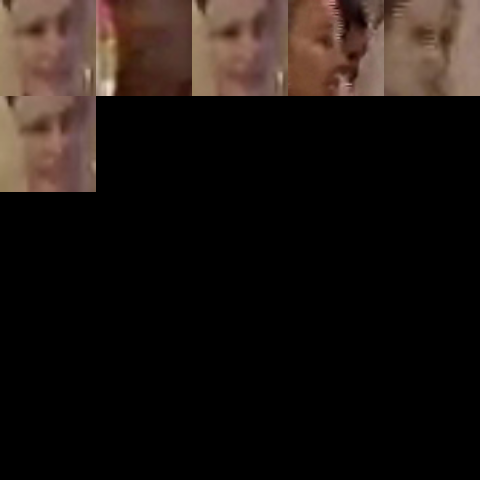

[INFO] faces for face ID: 0
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  89  90  91
  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 108 109 110
 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128
 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144]


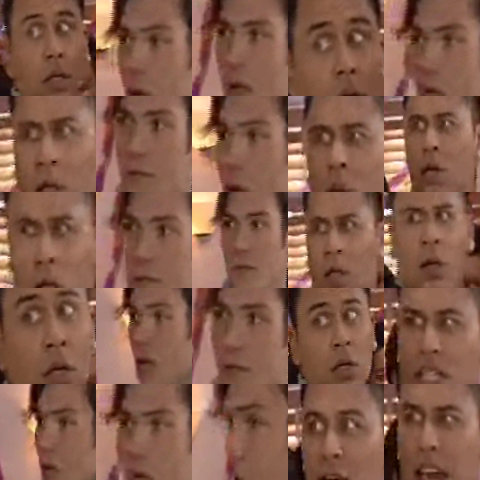

[INFO] faces for face ID: 1
[150 152 153 159 162 163 165 167 169 171 173 176 177 178 179 180 181 182
 183 184 185 186 187 188 190 192 194 195 196 197 198 199 200 201 202 203
 204 205 207 208 209]


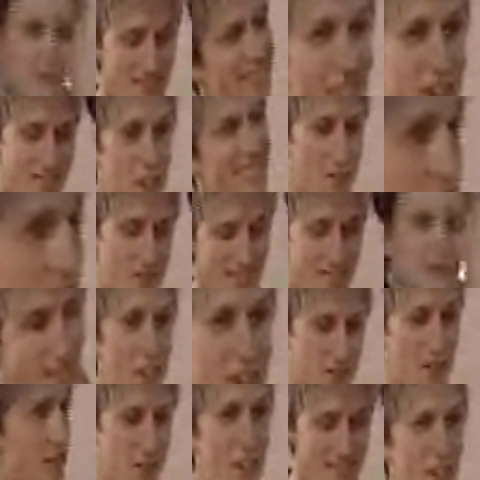

[INFO] faces for face ID: 2
[107 145 147 151 154 155 156 157 158 160 161 164 166 168 170 172 174 175
 189 191 193]


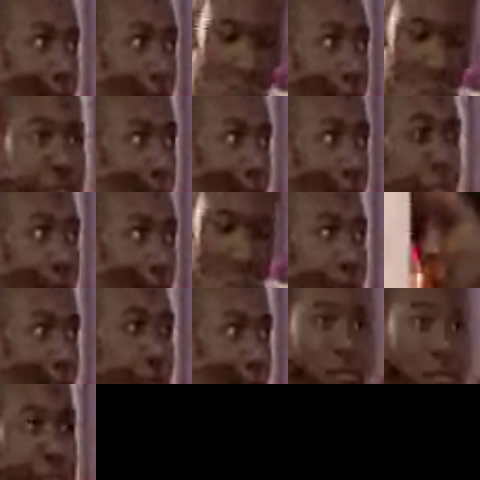

In [ ]:
#%%writefile cluster_faces.py
#from config import configurations
from sklearn.cluster import DBSCAN
from imutils import build_montages
import numpy as np
import pickle
import cv2
from google.colab.patches import cv2_imshow

# load the serialized face encodings + bounding box locations from
# disk, then extract the set of encodings so we can cluster them
configurations = {
    1: dict(
        encodings = '/content/drive/MyDrive/Cao Học/ThiGiacUngDung/baitap/FaceRecognition/faces_dataset/tv16.person.example.shots/shot157_199/shot_loc_enc.hdf5', # đường dẫn đến serialized db của các facial encodings
        jobs = 1, # of parallel jobs to run (-1 will use all CPUs)
        
),
}
cfg = configurations[1]



print("[INFO] loading encodings...")
data = pickle.loads(open(cfg["encodings"],"rb").read())
data = np.array(data)
encodings = [d["encoding"] for d in data]
#print(encodings)
# cluster the embeddings
print("[INFO] clustering...")
clt = DBSCAN(metric="euclidean", n_jobs=cfg["jobs"])
clt.fit(encodings)
# determine the total number of unique faces found in the dataset
labelIDs = np.unique(clt.labels_)
print(clt.labels_)
numUniqueFaces = len(np.where(labelIDs > -1)[0])
print(np.where(labelIDs > -1))
print("[INFO] # unique faces : {}".format(numUniqueFaces))
d = []
# loop over the unique face integers
for labelID in labelIDs:
    # find all the indexes into the 'data' array that belong to the
    # current label ID, then randomly sample a maximum of 25 index from the set
    print("[INFO] faces for face ID: {}".format(labelID))
    idxs = np.where(clt.labels_ == labelID)[0]
    print(idxs)
    idxs = np.random.choice(idxs, size=min(25, len(idxs)), replace=False)
    # initialize the list of faces to include in the montage
    faces = []
    # loop over the sampled indexes
    for i in idxs:
        # load the input image and extract the face ROI
        image = cv2.imread(data[i]["imagePath"])   
        (top, right, bottom, left) = data[i]["loc"]
        face = image[top:bottom, left:right]       
        # force resize the face ROI to 96x96 and then add it to the
        # faces montage list
        face = cv2.resize(face, (96,96))
        faces.append(face)
    # create a montage using 96x96 "tiles" with 5 rows and 5 columns
    montage = build_montages(faces, (96,96), (5,5))[0]
    # show the output montage
    title = "Face ID #{}".format(labelID)
    title = "Unknown Faces" if labelID == -1 else title
    cv2_imshow(montage)  

Đoạn code này tạo ra file cluster_faces.py
- Đầu vào : 2 tham số
  - --encoding_shot : file .hdf5 chứa thông tin embedding, location của các frame trong shot
  - --job : hình thức chạy, -1 chạy trên CPU
- Đầu ra : file clustering_shot.hdf5 chứa thông tin về các cluster trong shot, và nhóm con các encoding của cluster (phục vụ cho công việc tìm kiếm nhanh)

In [ ]:
%%writefile cluster_faces.py
from sklearn.cluster import DBSCAN
from imutils import build_montages
import numpy as np
import pickle
import cv2
import argparse
import time
import os

ap = argparse.ArgumentParser()
ap.add_argument("-d", "--encoding_shot", required=False, default="tv16.person.example.shots/shot157_199/shot_loc_enc.hdf5", help="path to input encoding shot file")
ap.add_argument("-m", "--jobs", type=str, default=1, help="# of parallel jobs to run (-1 will use all CPUs)")

def get_command_line_args():
    args = vars(ap.parse_args())
    return args['encoding_shot'],args['jobs']
encodings_file, jobs = get_command_line_args()
folderPath = os.path.dirname(encodings_file)
print("[INFO] loading encodings...")
data = pickle.loads(open(encodings_file,"rb").read())
data = np.array(data)
encodings = [d["encoding"] for d in data]
# cluster the embeddings
print("[INFO] clustering...")
clt = DBSCAN(metric="euclidean", n_jobs=jobs)
clt.fit(encodings)
# xác định tổng số unique faces có trong dataset
labelIDs = np.unique(clt.labels_)
numUniqueFaces = len(np.where(labelIDs > -1)[0])
print("[INFO] # unique faces : {}".format(numUniqueFaces))
dts = []
# loop trên các unique face 
for labelID in labelIDs:
    # tìm tất cả indexes trong 'data' array có label ID, sau đó lấy mẫu ngẫu nhiên tối đa 25 index từ tập dữ liệu
    print("[INFO] faces for face ID: {}".format(labelID))
    idxs = np.where(clt.labels_ == labelID)[0]
    idxs_choice = np.random.choice(idxs, size=min(25, len(idxs)), replace=False)
    print("Encodings group for Face ID #{} have been saved".format(labelID))
    encodings = [data[i]['encoding'] for i in idxs_choice]
    dt = {'sub_enc': encodings, 'idxs': idxs,'label' : labelID}
    dts.append(dt)
# dump các indexs của face Id vào disk
folderPath = os.path.join(folderPath,"clustering_shot.hdf5")
f = open(folderPath, "wb")
f.write(pickle.dumps(dts))
f.close()  

Overwriting cluster_faces.py


In [ ]:
!python3 cluster_faces.py

[INFO] loading encodings...
[INFO] clustering...
[INFO] # unique faces : 3
[INFO] faces for face ID: -1
Encodings group for Face ID #-1 have been saved
[INFO] faces for face ID: 0
Encodings group for Face ID #0 have been saved
[INFO] faces for face ID: 1
Encodings group for Face ID #1 have been saved
[INFO] faces for face ID: 2
Encodings group for Face ID #2 have been saved


In [ ]:
pwd

'/content/drive/MyDrive/Cao Học/ThiGiacUngDung/baitap/FaceRecognition/faces_dataset'

Xác định trong shot có nhân vật cần tìm hay không
- Input : 
    - Image nhân vật cần tìm
    - File clustering_shot chứa thông tin clustering các nhân vật của shot
- Output : 
    Tên nhân vật, hoặc unknown nếu không tìm thấy nhân vật trong shot     

In [ ]:
%%writefile find_character_in_shot.py
import numpy as np
import face_recognition
import pickle
import argparse
import cv2
import os
"""
Example images:
"""
ap = argparse.ArgumentParser()
ap.add_argument("-c", "--clustering", help="đường dẫn đến serialized db của các clustering index face")
ap.add_argument("-i", "--input_image", help="đường dẫn đến file image nhân vật")
ap.add_argument("-m", "--detection_method", default = 'hog' , help="face detection model to use: either 'hog' or 'cnn'")
def get_command_line_args():
    args = vars(ap.parse_args())
    return args['clustering'],args['input_image'],args['detection_method']

clustering_shot, input_image, detection_method = get_command_line_args()

print("[INFO] loading clustering shot...")
cluster = pickle.loads(open(clustering_shot, 'rb').read())
cluster = np.array(cluster)
# load input image và convert từ BGR sang RGB
image = cv2.imread(input_image)
rgb_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
print("[INFO] recognize faces...")
boxes = face_recognition.face_locations(rgb_image, model=detection_method)
print(boxes)
encoding = face_recognition.face_encodings(rgb_image, boxes)[0]
print(encoding)
name = "unknown"
# duyệt qua từng cluster
for d in cluster:
    # thử match image đầu vào với các face trong cluster, chỉ lấy cluster mà matching > 50% tổng số face trong cluster 
    matches = face_recognition.compare_faces(d["sub_enc"], encoding)
    matches = np.asarray(matches)
    len_arr = len(matches)/2
    if True in matches:
        if len(np.where(matches == True)[0]) >= len_arr:
            name = input_image.split(os.path.sep)[-2]
print(name)


Overwriting find_character_in_shot.py


ví dụ này, chạy script find_character_in_shot.py , truyền vào shot157_199 và image chứa hình ảnh của nhân vật fatboy, kết quả trả về fatboy 

In [ ]:
!python3 find_character_in_shot.py --clustering 'tv16.person.example.shots/shot157_199/clustering_shot.hdf5' --input_image '/content/drive/MyDrive/Cao Học/ThiGiacUngDung/baitap/FaceRecognition/faces_dataset/train/fatboy/fatboy.1.png'

[INFO] loading clustering shot...
[INFO] recognize faces...
[(140, 617, 247, 509)]
[-4.96953875e-02  1.94850087e-01  4.36552092e-02  2.38641351e-03
 -9.40852389e-02 -4.29931283e-03 -3.87385413e-02 -6.80671930e-02
  1.59505397e-01  5.30751050e-03  2.45573521e-01  4.85401750e-02
 -1.88817799e-01 -7.49453232e-02 -6.50835037e-02  9.86027196e-02
 -1.56514093e-01 -7.44478181e-02 -2.81294174e-02 -8.37710500e-03
  1.69006810e-01  7.07285777e-02  8.38936344e-02  4.49102223e-02
 -1.33734256e-01 -2.81038433e-01 -8.09845850e-02 -9.51498598e-02
  9.90394205e-02 -9.87543613e-02 -3.71284634e-02  2.92260461e-02
 -1.86934903e-01 -8.52195024e-02  5.08274361e-02  6.98025376e-02
 -3.64297181e-02  2.03073025e-04  1.72924131e-01  4.91784215e-02
 -1.79271758e-01  5.92310578e-02  8.83374363e-03  2.90197432e-01
  2.26491779e-01  7.27347136e-02  5.52938618e-02 -1.42290384e-01
  8.50704163e-02 -2.55443811e-01  1.08741030e-01  1.62769556e-01
  1.05473265e-01  2.35967562e-02  4.99491729e-02 -1.80343613e-01
 -1.336

Đoạn code này tạo ra file list_character_in_shot.py, 
- đầu vào có 4 tham số
  - --encoding_shot : file chứa dữ liệu encoding của shot
  - --index_cluster : file chứa thông tin clustering của shot
  - --input_image : file image nhân vật cần tìm
- đầu ra : xác định trong shot có nhân vật cần tìm không, nếu có thì ở tại những frame nào

In [ ]:
%%writefile list_character_in_shot.py
# import the necessary packages
import numpy as np
import face_recognition
import pickle
import argparse
import cv2
import os
"""
Example images:
"""
ap = argparse.ArgumentParser()
ap.add_argument("-e", "--encoding_shot", help="đường dẫn đến file dữ liệu encoding shot")
ap.add_argument("-c", "--index_cluster", help="đường dẫn đến file cluster shot")
ap.add_argument("-i", "--input_image", help="đường dẫn đến file image nhân vật")
ap.add_argument("-o", "--output", help="đường dẫn đến file output ")
ap.add_argument("-m", "--detection_method", default = 'hog' , help="face detection model to use: either 'hog' or 'cnn'")
def get_command_line_args():
    args = vars(ap.parse_args())
    return args['encoding_shot'],args['index_cluster'],args['input_image'],args['output'],args['detection_method']

encoding_shot, index_cluster, input_image, output, detection_method = get_command_line_args()

# load thông tin cluster trong shot
print("[INFO] loading encodings...")
cluster = pickle.loads(open(index_cluster, 'rb').read())
cluster = np.array(cluster)
# load dữ liệu embedding của shot
data = pickle.loads(open(encoding_shot, 'rb').read())
data = np.array(data)
# load image đầu vào và convert sang RGB
image = cv2.imread(input_image)
rgb_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

print("[INFO] recognize faces...")
boxes = face_recognition.face_locations(rgb_image, model=detection_method)
encoding = face_recognition.face_encodings(rgb_image, boxes)[0]
dt = []
# duyệt qua từng cluster
for d in cluster:
    encodings = [data[i]['encoding'] for i in d['idxs']]
    # tạo danh sách embedding từ dữ liệu cluster index, matching với image đầu vào
    # nếu matching > 50% , tạo dictionary chứa thông tin frame, encoding, tên nhân vật
    # hiển thị và lưu vào file output
    matches = face_recognition.compare_faces(encodings, encoding)
    matches = np.asarray(matches)
    len_arr = len(matches)/2
    if True in matches:
        if len(np.where(matches == True)[0]) >= len_arr:
            name = input_image.split(os.path.sep)[-2]
            matchedIdxs = [j for (j, b) in enumerate(matches) if b]
            # loop over the matched indexes and maintain a count for each recognized face face
            for k in matchedIdxs:
                idx = d['idxs'][k]
                #print(idx)
                frame = data[idx]['imagePath']
                encodingf = data[idx]['encoding']             
                dic = { "name": name, "path": frame, "encoding": encodingf }
                dt.append(dic)
for character in np.asarray(dt):
    print(character['name'])
    print('at frame of shot')
    print(character['path'])
# dump the indexs for face Id to disk
f = open(output, "wb")
f.write(pickle.dumps(dt))
f.close()      

Overwriting list_character_in_shot.py


In [ ]:
!python3 list_character_in_shot.py --encoding_shot 'tv16.person.example.shots/shot157_199/shot_loc_enc.hdf5' --index_cluster 'tv16.person.example.shots/shot157_199/clustering_shot.hdf5' --input_image 'train/fatboy/fatboy.1.png' --output 'tv16.person.example.shots/shot157_199/character_frame_shot.hdf5'

[INFO] loading encodings...
[INFO] recognize faces...
fatboy
at frame of shot
tv16.person.example.shots/shot157_199/frame_1.png
fatboy
at frame of shot
tv16.person.example.shots/shot157_199/frame_2.png
fatboy
at frame of shot
tv16.person.example.shots/shot157_199/frame_3.png
fatboy
at frame of shot
tv16.person.example.shots/shot157_199/frame_4.png
fatboy
at frame of shot
tv16.person.example.shots/shot157_199/frame_5.png
fatboy
at frame of shot
tv16.person.example.shots/shot157_199/frame_6.png
fatboy
at frame of shot
tv16.person.example.shots/shot157_199/frame_7.png
fatboy
at frame of shot
tv16.person.example.shots/shot157_199/frame_8.png
fatboy
at frame of shot
tv16.person.example.shots/shot157_199/frame_9.png
fatboy
at frame of shot
tv16.person.example.shots/shot157_199/frame_10.png
fatboy
at frame of shot
tv16.person.example.shots/shot157_199/frame_11.png
fatboy
at frame of shot
tv16.person.example.shots/shot157_199/frame_12.png
fatboy
at frame of shot
tv16.person.example.shots/shot1